# Simulation using Concord

In [2]:
%load_ext autoreload
%autoreload 2

In [12]:
import numpy as np
import scanpy as sc
import time
from pathlib import Path
import torch
import Concord as ccd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib as mpl
import pandas as pd

from matplotlib import font_manager, rcParams
custom_rc = {
    'font.family': 'Arial',  # Set the desired font for this plot
}

mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['pdf.fonttype'] = 42
custom_rc = {
    'font.family': 'Arial',  # Set the desired font for this plot
}


In [4]:
proj_name = "simulation_result_integration"
save_dir = f"../save/dev_{proj_name}-{time.strftime('%b%d')}/"
save_dir = Path(save_dir)
save_dir.mkdir(parents=True, exist_ok=True)

data_dir = f"../data/{proj_name}/"
data_dir = Path(data_dir)
data_dir.mkdir(parents=True, exist_ok=True)
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
print(device)
seed = 0
ccd.ul.set_seed(seed)

file_suffix = f"{time.strftime('%b%d-%H%M')}"
file_suffix

cpu


'Feb16-1314'

In [5]:
adata_list = {
    'cluster_full': '../data/simulation_cluster/adata_Nov29-1033.h5ad',
    'cluster_partial': '../data/simulation_cluster_overlap/adata_Dec03-1059.h5ad',
    'trajectory_full': '../data/simulation_trajectory/adata_Nov24-2032.h5ad',
    'trajectory_partial': '../data/simulation_trajectory_overlap/adata_Nov24-1414.h5ad',
    'trajectory_connected' : '../data/simulation_trajectory_nooverlap/adata_Nov25-1451.h5ad',
    'trajectory_gap' : '../data/simulation_trajectory_wtgap/adata_Nov24-2111.h5ad',
    'loop_full' : '../data/simulation_oneloop_full/adata_simulation_oneloop_full_Dec12-1440.h5ad',
    'loop_partial' : '../data/simulation_oneloop_partial/adata_simulation_oneloop_partial_Dec12-1721.h5ad',
    'loop_connected' : '../data/simulation_oneloop_connected/adata_simulation_oneloop_connected_Dec12-1751.h5ad',
    'loop_gap' : '../data/simulation_oneloop_gap/adata_simulation_oneloop_gap_Dec12-1824.h5ad',
    'tree_full' : '../data/simulation_tree/adata_Dec04-1057.h5ad',
    'tree_partial' : '../data/simulation_tree_overlap/adata_Dec06-0808.h5ad',
    'tree_connected' : '../data/simulation_tree_connected/adata_Dec06-1022.h5ad',
    'tree_gap': '../data/simulation_tree_gap/adata_Dec06-1213.h5ad',
}

In [6]:
latent_keys = ["Unintegrated", "Scanorama", "Liger", "Harmony", "scVI", "scANVI", "Concord", 'Concord-decoder', "Concord-class"]
ground_keys = ['PCA_no_noise', 'PCA_wt_noise']
combined_keys = ground_keys + latent_keys 

### topology

In [6]:

diagram_list = {
    'cluster_full': '../save/dev_simulation_cluster-Nov29/topology_diagrams_Nov29-1033.pkl',
    'cluster_partial': '../save/dev_simulation_cluster_overlap-Dec03/topology_diagrams_Dec03-1059.pkl',
    'trajectory_full': '../save/dev_simulation_trajectory-Nov24/topology_diagrams_Nov24-2032.pkl',
    'trajectory_partial': '../save/dev_simulation_trajectory_overlap-Nov24/topology_diagrams_Nov24-2026.pkl',
    'trajectory_connected': '../save/dev_simulation_trajectory_nooverlap-Nov26/topology_diagrams_Nov26-1109.pkl',
    'trajectory_gap': '../save/dev_simulation_trajectory_wtgap-Nov26/topology_diagrams_Nov26-1448.pkl',
    'loop_full': '../save/dev_simulation_oneloop_full-Dec12/topology_diagrams_simulation_oneloop_full_Dec12-1440.pkl',
    'loop_partial': '../save/dev_simulation_oneloop_partial-Dec12/topology_diagrams_simulation_oneloop_partial_Dec12-1721.pkl',
    'loop_connected': '../save/dev_simulation_oneloop_connected-Dec12/topology_diagrams_simulation_oneloop_connected_Dec12-1751.pkl',
    'loop_gap': '../save/dev_simulation_oneloop_gap-Dec12/topology_diagrams_simulation_oneloop_gap_Dec12-1824.pkl',
    'tree_full': '../save/dev_simulation_tree-Dec04/topology_diagrams_Dec04-1057.pkl',
    'tree_partial': '../save/dev_simulation_tree_overlap-Dec06/topology_diagrams_Dec06-0808.pkl',
    'tree_connected': '../save/dev_simulation_tree_connected-Dec06/topology_diagrams_Dec06-1022.pkl',
    'tree_gap': '../save/dev_simulation_tree-Dec04/topology_diagrams_Dec04-0819.pkl',
}

expectedbetti_list = {
    'cluster_full' : (4,0,0),
    'cluster_partial' : (4,0,0),
    'trajectory_full' : (0,0,0),
    'trajectory_partial' : (0,0,0),
    'trajectory_connected' : (0,0,0),
    'trajectory_gap' : (1,0,0),
    'loop_full' : (0,1,0),
    'loop_partial' : (0,1,0),
    'loop_connected' : (0,1,0),
    'loop_gap' : (1,0,0),
    'tree_full' : (0,0,0),
    'tree_partial' : (0,0,0),
    'tree_connected' : (0,0,0),
    'tree_gap' : (4,0,0),
}

In [7]:
import pickle
drop_methods = ['Concord-class', 'Concord-decoder', 'scANVI']
topology_res = {}
for key, val in diagram_list.items():
    print(f"Processing {key}")
    with open(val, 'rb') as f:
        diagrams = pickle.load(f)
    
    expected_betti_numbers = expectedbetti_list[key]
    topology_results = ccd.ul.benchmark_topology(diagrams, expected_betti_numbers=expectedbetti_list[key], save_dir=save_dir, file_suffix=file_suffix)
    max_betti = np.max(expected_betti_numbers) * 2
    topology_metrics = topology_results['combined_metrics'].drop(index=['PCA_no_noise', 'PCA_wt_noise'])
    topology_metrics[('Betti number', 'L1 distance')] = topology_metrics[('Betti number', 'L1 distance')].clip(upper=max_betti)

    topology_df = topology_metrics.copy()

    # Rename row name "no_noise_PCA" to "no_noise", "wt_noise_PCA" to "wt_noise"
    topology_df.rename(
        index={
            "no_noise_PCA": "no_noise",
            "wt_noise_PCA": "wt_noise"
        },
        inplace=True
    )

    topology_df[("Topological metrics", "Betti curve stability")] = topology_df["Betti curve"][
        ["Entropy"]
    ]
    topology_df[("Topological metrics", "Betti number accuracy")] = topology_df["Betti number"][
        ["L1 distance"]
    ]

    topology_df.drop(
        columns=[
            ("Betti curve", "Variance"),
            ("Betti curve", "Entropy"),
            ("Betti number", "L1 distance")
        ],
        inplace=True
    )

    agg_name1 = ''
    agg_name2 = 'Topology Score'
    topology_scores = ccd.ul.benchmark_stats_to_score(topology_df.drop(index=drop_methods), min_max_scale=True, one_minus=True, aggregate_score=False, aggregate_score_name1=None, aggregate_score_name2=None, rank=False, rank_col=None, name_exact=False)
    # Weight the metrics
    topology_scores[("", "Topology Score")] = topology_scores[("Topological metrics", "Betti curve stability")]*0.2 + topology_scores[("Topological metrics", "Betti number accuracy")]*0.8

    topology_res[key] = topology_scores


Processing cluster_full
Processing cluster_partial
Processing trajectory_full
Processing trajectory_partial
Processing trajectory_connected
Processing trajectory_gap
Processing loop_full
Processing loop_partial
Processing loop_connected
Processing loop_gap
Processing tree_full
Processing tree_partial
Processing tree_connected
Processing tree_gap


In [15]:
import pickle
with open(save_dir / f"topology_results_{file_suffix}.pkl", 'wb') as f:
    pickle.dump(topology_res, f)

In [10]:
with open(Path("../save/dev_simulation_result_integration-Feb09/") / f"topology_results_Feb09-1436.pkl", 'rb') as f:
    topology_res = pickle.load(f)

In [11]:
import pandas as pd
na_metrics = ['trajectory_gap', 'loop_gap', 'tree_gap']
with pd.ExcelWriter(save_dir/f"topology_results_{file_suffix}.xlsx", engine="xlsxwriter") as writer:
    for sheet_name, df in topology_res.items():
        if sheet_name in na_metrics:
            continue
        df.to_excel(writer, sheet_name=sheet_name)

In [12]:
# Combine scores into a single table
# Get individual score as scores = connectivity_res['cluster_full'][('Connectivity', 'Score')]
score_key = ('', 'Topology Score')
import pandas as pd
topology_scores = {}
na_metrics = ['trajectory_gap', 'loop_gap', 'tree_gap']
for key, val in topology_res.items():
    if key in na_metrics:
        # Set the score to NA
        topology_scores[key] = np.nan
    else:
        topology_scores[key] = val[score_key]
topology_scores = pd.DataFrame(topology_scores)
method_order = ["Unintegrated", "Scanorama", "Liger", "Harmony", "scVI", "Concord"]
topology_scores = topology_scores.loc[method_order, :]
topology_scores


,cluster_full,cluster_partial,trajectory_full,trajectory_partial,trajectory_connected,trajectory_gap,loop_full,loop_partial,loop_connected,loop_gap,tree_full,tree_partial,tree_connected,tree_gap
Method,,,,,,,,,,,,,,
Unintegrated,0.090077,0.054465,0.870045,0.918568,0.928386,NaN,0.033960,0.059234,0.200000,NaN,0.860505,0.904762,0.877566,NaN
Scanorama,0.121306,0.122902,0.882130,0.907817,0.878703,NaN,0.029148,0.000000,0.036862,NaN,0.851372,0.873435,0.800000,NaN
Liger,0.592796,0.934360,0.800000,0.814459,0.800000,NaN,0.400000,0.813843,0.001138,NaN,0.800000,0.800000,0.950742,NaN
Harmony,0.123389,0.119306,0.898601,0.921223,0.928396,NaN,0.037884,0.106113,0.140170,NaN,0.859995,0.850021,0.811701,NaN
scVI,0.000000,0.840000,0.881319,0.800000,0.891747,NaN,0.472971,0.839411,0.400000,NaN,1.000000,1.000000,1.000000,NaN
Concord,1.000000,0.640000,1.000000,1.000000,1.000000,NaN,1.000000,1.000000,0.994231,NaN,0.910563,0.928920,0.995126,NaN


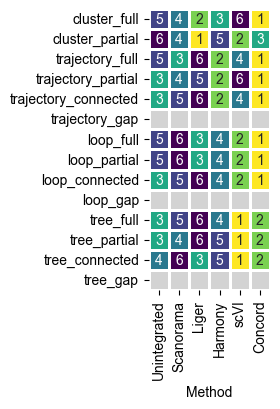

In [14]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Make a copy of scores
show_scores = topology_scores.copy()

# Metrics to set as NaN
na_metrics = ['trajectory_gap', 'loop_gap', 'tree_gap']  # Topology metrics should be set to NA
show_scores.loc[:, na_metrics] = np.nan

# Convert score to rank, ensuring integers
ranked = show_scores.rank(axis=0, ascending=False).astype("Int64")  # Keeps NaNs intact
# 3) Convert to plain float (NumPy float64)
heatmap_data = ranked.astype(float)

# 4) Create annotation text: If value is not NaN, show as integer; else show dash
annot_text = heatmap_data.applymap(lambda val: str(int(val)) if pd.notna(val) else "-")

# 5) Create a colormap that colors NaN as grey
cmap = sns.color_palette("viridis_r", as_cmap=True)
cmap.set_bad(color="lightgrey")  # cells with np.nan become light grey

with plt.rc_context(rc=custom_rc):
    plt.figure(figsize=(2.9, 4.2))
    # plot without color bar
    ax = sns.heatmap(
        heatmap_data.T,
        annot=annot_text.T,
        fmt="",            # So Seaborn won't auto-format numbers
        cmap=cmap,
        linewidths=1,      # White grid lines
        linecolor="white", # White border color
        cbar_kws={'label': 'Rank'},
        cbar=False
    )


# 7) Remove any facecolor override (so that NaN cells actually show as grey)
# ax.set_facecolor('lightgrey')  # Not needed now that cmap.set_bad() is in use

plt.tight_layout()
plt.savefig(save_dir / f"topology_rank_{file_suffix}.pdf")
plt.show()

### Geometry

In [15]:
statekey_dict = {
    'cluster_full' : 'cluster',
    'cluster_partial' : 'cluster',
    'trajectory_full' : 'leiden_no_noise',
    'trajectory_partial' : 'leiden_no_noise',
    'trajectory_connected' : 'leiden_no_noise',
    'trajectory_gap' : 'leiden_no_noise',
    'loop_full' : 'leiden_no_noise',
    'loop_partial' : 'leiden_no_noise',
    'loop_connected' : 'leiden_no_noise',
    'loop_gap' : 'leiden_no_noise',
    'tree_full' : 'branch',
    'tree_partial' : 'branch',
    'tree_connected' : 'branch',
    'tree_gap' : 'branch'
}

In [19]:
geometry_dfs = {}
geometry_fulls = {}
geometry_metrics = ['cell_distance_corr', 'local_distal_corr', 'trustworthiness', 'state_distance_corr', 'state_dispersion_corr', 'state_batch_distance_ratio']
dist_metric = 'cosine'
corr_types = ['pearsonr', 'spearmanr', 'kendalltau']
batch_key = 'batch'
#groundtruth_key = 'PCA_wt_noise'
groundtruth_key = 'PCA_no_noise'

for key, val in adata_list.items():
    print(f"Processing {key}")
    adata = sc.read(val)

    geometry_df, geometry_full = ccd.ul.benchmark_geometry(adata, keys=combined_keys, eval_metrics=geometry_metrics, 
                                        dist_metric=dist_metric,
                                        corr_types = corr_types,
                                        groundtruth_key = groundtruth_key,
                                        ground_truth_dispersion_key = 'PCA_wt_noise',
                                        state_key = statekey_dict[key],
                                        batch_key = batch_key,
                                        #groundtruth_dispersion = groundtruth_dispersion,
                                        dispersion_metric='var',
                                        return_type='full',
                                        start_point=0,
                                        end_point=adata.n_obs-1,
                                        pseudotime_k = 30,
                                        truetime_key = 'time',
                                        save_dir=save_dir, 
                                        file_suffix=file_suffix)
    geometry_fulls[key] = geometry_full
    geometry_dfs[key] = geometry_df

Processing cluster_full
Concord - INFO - Computing cell distance correlation
Concord - INFO - Computing local vs distal correlation
Concord - INFO - Computing trustworthiness
Concord - INFO - Computing cluster centroid distances correlation
Concord - INFO - Computing state dispersion correlation
Concord - INFO - Computing state-batch distance ratio
Processing cluster_partial
Concord - INFO - Computing cell distance correlation
Concord - INFO - Computing local vs distal correlation
Concord - INFO - Computing trustworthiness
Concord - INFO - Computing cluster centroid distances correlation
Concord - INFO - Computing state dispersion correlation
Concord - INFO - Computing state-batch distance ratio
Processing trajectory_full
Concord - INFO - Computing cell distance correlation
Concord - INFO - Computing local vs distal correlation
Concord - INFO - Computing trustworthiness
Concord - INFO - Computing cluster centroid distances correlation
Concord - INFO - Computing state dispersion correla

In [20]:
import pickle
with open(save_dir / f"geometry_fulls_{file_suffix}.pkl", 'wb') as f:
    pickle.dump(geometry_fulls, f)
with open(save_dir / f"geometry_dfs_{file_suffix}.pkl", 'wb') as f:
    pickle.dump(geometry_dfs, f)
print(file_suffix)

Feb15-2245


In [21]:
drop_methods = ['Concord-class', 'Concord-decoder', 'scANVI', 'PCA_no_noise', 'PCA_wt_noise']
geometry_dfs_simplified = {}
for key, val in geometry_dfs.items():
    res_df = ccd.ul.simplify_geometry_benchmark_table(val)
    # Drop column ('State/batch', 'Distance ratio (log10)')
    if key in ['cluster_full', 'cluster_partial']:
        drop_cols = [("Geometric metrics", "State distance correlation"), ('State/batch', 'Distance ratio (log10)')]
    else:
        drop_cols = [("Geometric metrics", "State distance correlation"), ('State/batch', 'Distance ratio (log10)'), ('Geometric metrics', 'State dispersion correlation')]
    geometry_dfs_simplified[key] = res_df.drop(columns=drop_cols, index=drop_methods)

In [22]:
geometry_dfs_simplified['loop_full']

Geometric metrics                
             Cell distance correlation Trustworthiness
Unintegrated                  0.496910        0.928869
Scanorama                     0.814339        0.949129
Liger                         0.689218        0.924549
Harmony                       0.792262        0.938940
scVI                          0.833345        0.964945
Concord                       0.899294        0.979747

In [23]:
import pandas as pd
with pd.ExcelWriter(save_dir/f"geometry_results_{file_suffix}.xlsx", engine="xlsxwriter") as writer:
    for sheet_name, df in geometry_dfs_simplified.items():
        df.to_excel(writer, sheet_name=sheet_name)

In [24]:
geometry_scores = {}
agg_name1 = ''
agg_name2 = 'Geometric Score'
for key, val in geometry_dfs_simplified.items():
    geometry_scores[key] = ccd.ul.benchmark_stats_to_score(val, fillna = 0,               
        min_max_scale=True, one_minus=False, aggregate_score=True, aggregate_score_name1=agg_name1, aggregate_score_name2=agg_name2, rank=True, rank_col=(agg_name1,agg_name2))

In [25]:
score_key = ('', 'Geometric Score')
import pandas as pd
geometric_scores = {}
for key, val in geometry_scores.items():
    geometric_scores[key] = val[score_key]
geometric_scores= pd.DataFrame(geometric_scores)

all_topologies = adata_list.keys()
# Order by all_topologies, fill in NA for missing keys
geometric_scores = geometric_scores.reindex(all_topologies, axis=1)
# order based on method order
method_order = ["Unintegrated", "Scanorama", "Liger", "Harmony", "scVI", "Concord"]
geometric_scores = geometric_scores.loc[method_order, :]

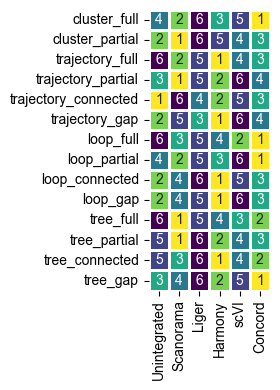

In [27]:
# Score as heatmap
import seaborn as sns
import matplotlib.pyplot as plt
ranked = geometric_scores.rank(axis=0, ascending=False).astype("Int64")  # Keeps NaNs intact
# 3) Convert to plain float (NumPy float64)
heatmap_data = ranked.astype(float)

# 4) Create annotation text: If value is not NaN, show as integer; else show dash
annot_text = heatmap_data.applymap(lambda val: str(int(val)) if pd.notna(val) else "-")

# 5) Create a colormap that colors NaN as grey
cmap = sns.color_palette("viridis_r", as_cmap=True)
cmap.set_bad(color="lightgrey")  # cells with np.nan become light grey

with plt.rc_context(rc=custom_rc):
    plt.figure(figsize=(2.9, 4))
    # plot without color bar
    ax = sns.heatmap(
        heatmap_data.T,
        annot=annot_text.T,
        fmt="",            # So Seaborn won't auto-format numbers
        cmap=cmap,
        linewidths=1,      # White grid lines
        linecolor="white", # White border color
        cbar_kws={'label': 'Rank'},
        cbar=False
    )

# 7) Remove any facecolor override (so that NaN cells actually show as grey)
# ax.set_facecolor('lightgrey')  # Not needed now that cmap.set_bad() is in use

plt.tight_layout()
plt.savefig(save_dir / f"geometry_rank_{file_suffix}.pdf")
plt.show()

### Scib

In [47]:
from scib_metrics.benchmark import Benchmarker

scib_res = {}
for key, val in adata_list.items():
    print(f"Processing {key}")
    adata = sc.read(val)
    try:
        bm = Benchmarker(
            adata,
            batch_key=batch_key,
            label_key=statekey_dict[key],
            embedding_obsm_keys=latent_keys,
            n_jobs=1,
        )
        bm.benchmark()
        scib_scores = bm.get_results(min_max_scale=False)
        scib_res[key] = scib_scores
    except:
        print(f"Error processing {key}")


Processing cluster_full


Embeddings:   0%|          | 0/9 [00:00<?, ?it/s]


Error processing cluster_full
Processing cluster_partial


Embeddings:   0%|          | 0/9 [00:00<?, ?it/s]

INFO     cluster_1 consists of a single batch or is too small. Skip.                                               
INFO     cluster_2 consists of a single batch or is too small. Skip.                                               
INFO     cluster_4 consists of a single batch or is too small. Skip.                                               
INFO     cluster_5 consists of a single batch or is too small. Skip.                                               


Embeddings:   0%|          | 0/9 [00:00<?, ?it/s]


Error processing cluster_partial
Processing trajectory_full


Embeddings:   0%|          | 0/9 [00:00<?, ?it/s]


Error processing trajectory_full
Processing trajectory_partial


Computing neighbors:  56%|█████▌    | 5/9 [00:02<00:01,  2.15it/s]


Error processing trajectory_partial
Processing trajectory_connected


Embeddings:   0%|          | 0/9 [00:00<?, ?it/s]

INFO     0 consists of a single batch or is too small. Skip.                                                       
INFO     1 consists of a single batch or is too small. Skip.                                                       
INFO     10 consists of a single batch or is too small. Skip.                                                      
INFO     11 consists of a single batch or is too small. Skip.                                                      
INFO     12 consists of a single batch or is too small. Skip.                                                      
INFO     13 consists of a single batch or is too small. Skip.                                                      
INFO     14 consists of a single batch or is too small. Skip.                                                      
INFO     15 consists of a single batch or is too small. Skip.                                                      
INFO     17 consists of a single batch or is too small. Skip.           

Embeddings:   0%|          | 0/9 [00:00<?, ?it/s]


Error processing trajectory_connected
Processing trajectory_gap


Embeddings:   0%|          | 0/9 [00:00<?, ?it/s]


Error processing trajectory_gap
Processing loop_full


Embeddings:   0%|          | 0/9 [00:00<?, ?it/s]


Error processing loop_full
Processing loop_partial


Computing neighbors:  44%|████▍     | 4/9 [00:02<00:02,  1.98it/s]

: 

: 

In [41]:
import pickle
with open(save_dir / f"scib_results_{file_suffix}.pkl", 'wb') as f:
    pickle.dump(scib_res, f)

In [7]:
import pickle
with open(Path("../save/dev_simulation_result_integration-Feb09/") / f"scib_results_Feb09-1630.pkl", 'rb') as f:
    scib_res = pickle.load(f)

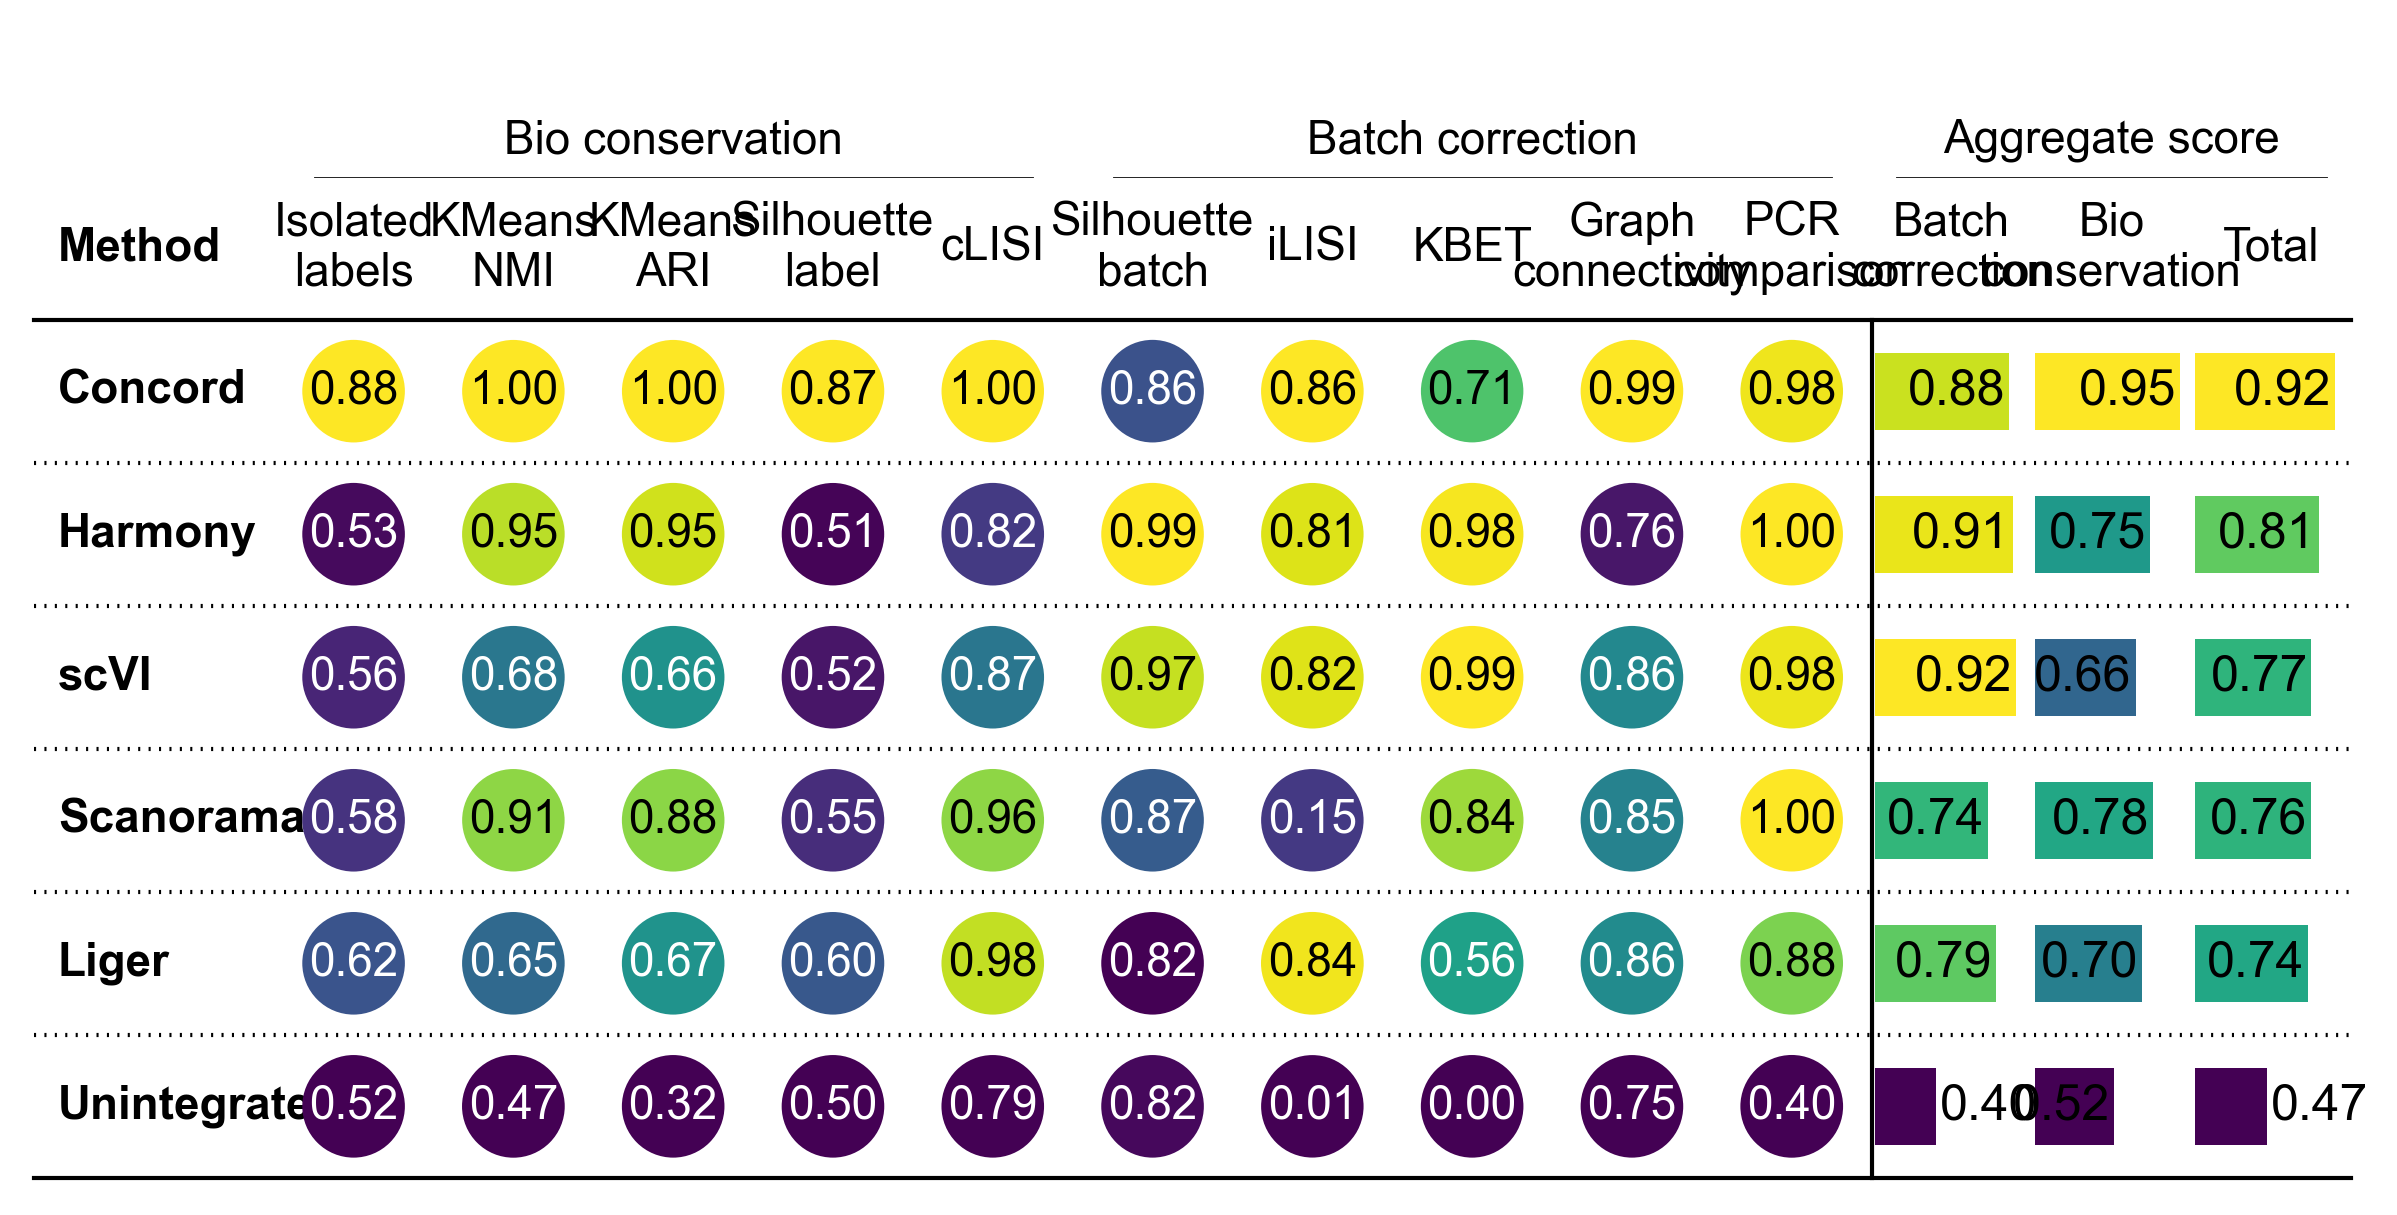

In [14]:
example_key = 'cluster_full'
drop_methods = ['Concord-class', 'Concord-decoder', 'scANVI']
with plt.rc_context(rc=custom_rc):
    cur_scores = scib_res[example_key].drop(index = drop_methods)
    # Convert row 'Metric Type' to multi-index column, first level is 'Metric Type', second level is existing column name
    metric_type = cur_scores.loc['Metric Type']
    cur_scores = cur_scores.drop('Metric Type')  # Drop the last row now that it's stored in metric_type
    cur_scores.columns = pd.MultiIndex.from_tuples([(metric_type[col], col) for col in cur_scores.columns])
    cur_scores = ccd.ul.benchmark_stats_to_score(cur_scores, min_max_scale=False, one_minus=False, aggregate_score=False, rank=True, rank_col=('Aggregate score', 'Total'), name_exact=False)
    ccd.pl.plot_benchmark_table(cur_scores, pal='viridis', pal_agg='viridis', cmap_method = 'minmax', agg_name = 'Aggregate score', save_path=save_dir / f"scib_results_{example_key}_{file_suffix}.pdf", figsize=(10, 5), dpi=300)

In [29]:
import pandas as pd
with pd.ExcelWriter(save_dir/f"scib_results_{file_suffix}.xlsx", engine="xlsxwriter") as writer:
    for sheet_name, df in scib_res.items():
        df.to_excel(writer, sheet_name=sheet_name)

In [15]:
# Combine scores into a single table
# Get individual score as scores = connectivity_res['cluster_full'][('Connectivity', 'Score')]
score_key = ('Batch correction')
#score_key = ('Bio conservation')
#score_key = ('Total')
drop_methods = ['Concord-class', 'Concord-decoder', 'scANVI']
import pandas as pd
scib_scores = {}
for key, val in scib_res.items():
    scib_scores[key] = val[score_key].drop(index = ['Metric Type']+drop_methods)
scib_scores = pd.DataFrame(scib_scores)

all_topologies = adata_list.keys()
# Order by all_topologies, fill in NA for missing keys
scib_scores = scib_scores.reindex(all_topologies, axis=1)
scib_scores


,cluster_full,cluster_partial,trajectory_full,trajectory_partial,trajectory_connected,trajectory_gap,loop_full,loop_partial,loop_connected,loop_gap,tree_full,tree_partial,tree_connected,tree_gap
Embedding,,,,,,,,,,,,,,
Unintegrated,0.395916,0.419885,0.212913,0.260052,0.26473,NaN,0.268176,0.29156,0.333262,NaN,0.222294,0.256608,0.288197,NaN
Scanorama,0.741537,0.576356,0.934041,0.764307,0.5088,NaN,0.747035,0.755026,0.64999,NaN,0.954342,0.754707,0.709465,NaN
Liger,0.79278,0.483289,0.593921,0.290392,0.383994,NaN,0.703464,0.590751,0.495747,NaN,0.683605,0.637899,0.62076,NaN
Harmony,0.905823,0.675315,0.937834,0.261555,0.293218,NaN,0.786481,0.758443,0.601308,NaN,0.835221,0.437015,0.34623,NaN
scVI,0.922523,0.402506,0.717421,0.705644,0.444721,NaN,0.909286,0.784796,0.687111,NaN,0.944237,0.425694,0.588113,NaN
Concord,0.880513,0.538744,0.936035,0.527986,0.596319,NaN,0.925554,0.551317,0.683998,NaN,0.960108,0.553247,0.642852,NaN


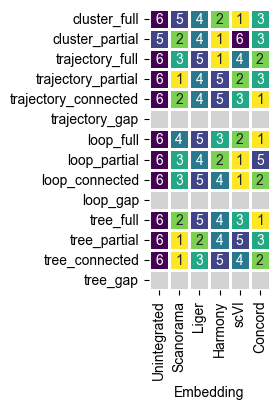

In [16]:
# Score as heatmap
import seaborn as sns
import matplotlib.pyplot as plt
ranked = scib_scores.rank(axis=0, ascending=False).astype("Int64")  # Keeps NaNs intact
# 3) Convert to plain float (NumPy float64)
heatmap_data = ranked.astype(float)

# 4) Create annotation text: If value is not NaN, show as integer; else show dash
annot_text = heatmap_data.applymap(lambda val: str(int(val)) if pd.notna(val) else "-")

# 5) Create a colormap that colors NaN as grey
cmap = sns.color_palette("viridis_r", as_cmap=True)
cmap.set_bad(color="lightgrey")  # cells with np.nan become light grey

# 6) Plot the heatmap WITHOUT a mask so that dashes appear
with plt.rc_context(rc=custom_rc):
    plt.figure(figsize=(2.9, 4.2))
    # plot without color bar
    ax = sns.heatmap(
        heatmap_data.T,
        annot=annot_text.T,
        fmt="",            # So Seaborn won't auto-format numbers
        cmap=cmap,
        linewidths=1,      # White grid lines
        linecolor="white", # White border color
        cbar_kws={'label': 'Rank'},
        cbar=False
    )



# 7) Remove any facecolor override (so that NaN cells actually show as grey)
# ax.set_facecolor('lightgrey')  # Not needed now that cmap.set_bad() is in use

plt.tight_layout()
plt.savefig(save_dir / f"scib_rank_{score_key}_{file_suffix}.pdf")
plt.show()

In [32]:
score_key = ('Batch correction')
drop_methods = ['Concord-class', 'Concord-decoder', 'scANVI']
import pandas as pd
batch_scores = {}
for key, val in scib_res.items():
    batch_scores[key] = val[score_key].drop(index = ['Metric Type']+drop_methods)
batch_scores = pd.DataFrame(batch_scores)

all_topologies = adata_list.keys()
# Order by all_topologies, fill in NA for missing keys
batch_scores = batch_scores.reindex(all_topologies, axis=1)
batch_scores

,cluster_full,cluster_partial,trajectory_full,trajectory_partial,trajectory_connected,trajectory_gap,loop_full,loop_partial,loop_connected,loop_gap,tree_full,tree_partial,tree_connected,tree_gap
Embedding,,,,,,,,,,,,,,
Unintegrated,0.395916,0.419885,0.212913,0.260052,0.26473,NaN,0.268176,0.29156,0.333262,NaN,0.222294,0.256608,0.288197,NaN
Scanorama,0.741537,0.576356,0.934041,0.764307,0.5088,NaN,0.747035,0.755026,0.64999,NaN,0.954342,0.754707,0.709465,NaN
Liger,0.79278,0.483289,0.593921,0.290392,0.383994,NaN,0.703464,0.590751,0.495747,NaN,0.683605,0.637899,0.62076,NaN
Harmony,0.905823,0.675315,0.937834,0.261555,0.293218,NaN,0.786481,0.758443,0.601308,NaN,0.835221,0.437015,0.34623,NaN
scVI,0.922523,0.402506,0.717421,0.705644,0.444721,NaN,0.909286,0.784796,0.687111,NaN,0.944237,0.425694,0.588113,NaN
Concord,0.880513,0.538744,0.936035,0.527986,0.596319,NaN,0.925554,0.551317,0.683998,NaN,0.960108,0.553247,0.642852,NaN


In [33]:
score_key = ('Bio conservation')
drop_methods = ['Concord-class', 'Concord-decoder', 'scANVI']
import pandas as pd
bio_scores = {}
for key, val in scib_res.items():
    bio_scores[key] = val[score_key].drop(index = ['Metric Type']+drop_methods)
bio_scores = pd.DataFrame(bio_scores)

all_topologies = adata_list.keys()
# Order by all_topologies, fill in NA for missing keys
bio_scores = bio_scores.reindex(all_topologies, axis=1)
bio_scores


,cluster_full,cluster_partial,trajectory_full,trajectory_partial,trajectory_connected,trajectory_gap,loop_full,loop_partial,loop_connected,loop_gap,tree_full,tree_partial,tree_connected,tree_gap
Embedding,,,,,,,,,,,,,,
Unintegrated,0.519961,0.621741,0.59354,0.650823,0.696273,NaN,0.551769,0.562157,0.614629,NaN,0.587807,0.638028,0.713388,NaN
Scanorama,0.776186,0.713086,0.660297,0.640107,0.632728,NaN,0.56551,0.547861,0.575974,NaN,0.647374,0.641428,0.654442,NaN
Liger,0.703796,0.64215,0.596142,0.617495,0.609425,NaN,0.510195,0.519222,0.547557,NaN,0.620576,0.635669,0.64959,NaN
Harmony,0.750974,0.61643,0.666812,0.651311,0.681495,NaN,0.563173,0.560829,0.621096,NaN,0.651301,0.657149,0.707516,NaN
scVI,0.660019,0.816936,0.666678,0.49408,0.721962,NaN,0.584371,0.462819,0.601325,NaN,0.845392,0.758074,0.767598,NaN
Concord,0.950377,0.800293,0.733833,0.68725,0.733445,NaN,0.632798,0.606735,0.640136,NaN,0.771486,0.789907,0.706125,NaN


In [34]:
# All scores combined
method_order = ["Unintegrated", "Scanorama", "Liger", "Harmony", "scVI", "Concord"]
geometric_scores = geometric_scores.loc[method_order, :]
geometric_rank = geometric_scores.rank(axis=0, ascending=False).astype("Int64")
topology_scores = topology_scores.loc[method_order, :]
topology_rank = topology_scores.rank(axis=0, ascending=False).astype("Int64")
batch_rank = batch_scores.rank(axis=0, ascending=False).astype("Int64")
bio_rank = bio_scores.rank(axis=0, ascending=False).astype("Int64")


# Get mean (na removed) across geometric_scores, topology_scores, bio_scores, batch_scores
dfs = [geometric_rank, topology_rank, batch_rank, bio_rank]

# Compute the element-wise mean while ignoring NaNs
summarized_rank = pd.concat(dfs).groupby(level=0).mean()
summarized_rank = summarized_rank.loc[method_order, :]
# Rerank
summarized_rank = summarized_rank.rank(axis=0, ascending=True)
summarized_rank

,cluster_full,cluster_partial,trajectory_full,trajectory_partial,trajectory_connected,trajectory_gap,loop_full,loop_partial,loop_connected,loop_gap,tree_full,tree_partial,tree_connected,tree_gap
Unintegrated,6.0,6.0,6.0,4.0,2.5,2.0,6.0,5.5,4.0,2.0,5.5,5.0,5.0,3.0
Scanorama,3.0,1.0,3.0,2.0,5.0,5.0,4.0,3.5,5.0,4.0,3.0,2.0,4.0,4.0
Liger,4.0,4.0,5.0,5.0,6.0,3.0,5.0,5.5,6.0,5.0,5.5,6.0,6.0,6.0
Harmony,2.0,5.0,1.0,3.0,2.5,1.0,3.0,2.0,2.0,1.0,4.0,4.0,3.0,2.0
scVI,5.0,3.0,4.0,6.0,4.0,6.0,2.0,3.5,3.0,6.0,2.0,3.0,1.5,5.0
Concord,1.0,2.0,2.0,1.0,1.0,4.0,1.0,1.0,1.0,3.0,1.0,1.0,1.5,1.0


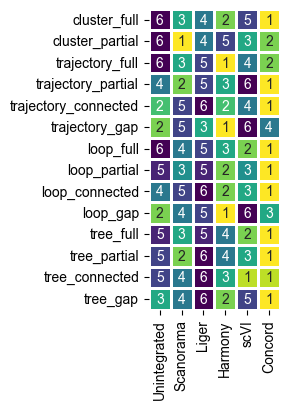

In [36]:
# Score as heatmap
import seaborn as sns
import matplotlib.pyplot as plt
# 3) Convert to plain float (NumPy float64)
heatmap_data = summarized_rank

# 4) Create annotation text: If value is not NaN, show as integer; else show dash
annot_text = heatmap_data.applymap(lambda val: str(int(val)) if pd.notna(val) else "-")

# 5) Create a colormap that colors NaN as grey
cmap = sns.color_palette("viridis_r", as_cmap=True)
cmap.set_bad(color="lightgrey")  # cells with np.nan become light grey

# 6) Plot the heatmap WITHOUT a mask so that dashes appear
with plt.rc_context(rc=custom_rc):
    plt.figure(figsize=(3, 4.2))
    # plot without color bar
    ax = sns.heatmap(
        heatmap_data.T,
        annot=annot_text.T,
        fmt="",            # So Seaborn won't auto-format numbers
        cmap=cmap,
        linewidths=1,      # White grid lines
        linecolor="white", # White border color
        cbar_kws={'label': 'Rank'},
        cbar=False
    )

# 7) Remove any facecolor override (so that NaN cells actually show as grey)
# ax.set_facecolor('lightgrey')  # Not needed now that cmap.set_bad() is in use

plt.tight_layout()
plt.savefig(save_dir / f"summary_rank_{file_suffix}.pdf")
plt.show()

In [394]:
geometry_scores 

{'cluster_full':                      Geometric metrics                  \
              Cell distance correlation Trustworthiness   
 Concord                       1.000000        0.921532   
 Scanorama                     0.898215        1.000000   
 Harmony                       0.830787        0.150200   
 Unintegrated                  0.458447        0.000000   
 scVI                          0.069241        0.209839   
 Liger                         0.000000        0.510330   
 
                                                            
              State dispersion correlation Geometric Score  
 Concord                          1.000000        0.973844  
 Scanorama                        0.721503        0.873240  
 Harmony                          0.998966        0.659984  
 Unintegrated                     0.998949        0.485799  
 scVI                             0.854335        0.377805  
 Liger                            0.000000        0.170110  ,
 'cluster_partial':  

In [403]:
all_topologies = adata_list.keys()
method_order = ["Unintegrated", "Scanorama", "Liger", "Harmony", "scVI", "Concord"]
combined_res = {}
for topo in all_topologies:
    geo_df = geometry_scores[topo]
    geo_df = geo_df.loc[method_order, :]
    geo_df[('Aggregate score', 'Geometry')] = geo_df[('', 'Geometric Score')]
    geo_df.drop(columns=[('', 'Geometric Score')], inplace=True)
    topo_df = topology_res[topo]
    topo_df = topo_df.loc[method_order, :]
    topo_df[('Aggregate score', 'Topology')] = topo_df[('', 'Topology Score')]
    topo_df.drop(columns=[('', 'Topology Score')], inplace=True)
    # Check if topo is in scib_res keys
    if topo not in scib_res.keys():
        scib_df = pd.DataFrame(index=method_order)
    else:
        scib_df = scib_res[topo]
        metric_type = scib_df.loc['Metric Type']
        scib_df = scib_df.drop('Metric Type')  # Drop the last row now that it's stored in metric_type
        scib_df.columns = pd.MultiIndex.from_tuples([(metric_type[col], col) for col in scib_df.columns])
        scib_df = scib_df.loc[method_order, :]
        scib_df.drop(columns=[('Aggregate score', 'Total')], inplace=True)
    
    combine_df = pd.concat([geo_df, topo_df, scib_df], axis=1)
    # Sort columns by level 0, the order match ['Topology', 'Geometry', 'Batch correction', 'Bio conservation', 'Aggregate score']
    col_order = ['Topological metrics', 'Geometric metrics', 'Batch correction', 'Bio conservation', 'Aggregate score']
    combine_df = combine_df.reindex(col_order, axis=1, level=0)
    combined_res[topo] = combine_df



In [405]:
import pandas as pd
with pd.ExcelWriter(save_dir/f"combined_results_{file_suffix}.xlsx", engine="xlsxwriter") as writer:
    for sheet_name, df in combined_res.items():
        df.to_excel(writer, sheet_name=sheet_name)